In [53]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import math
import aesara.tensor as at
import seaborn as sb

In [54]:
train_data = pd.read_csv("data_acquisition/data_0.3/data_game_values_train.csv", sep=";")

In [55]:
xg_mean = np.mean(np.mean(train_data["home_xG"]) + np.mean(train_data["away_xG"]))
xg_against_mean = np.mean(np.mean(train_data["home_xg_against"]) + np.mean(train_data["away_xg_against"]))

xt_mean = np.mean(np.mean(train_data["home_xT_all"]) + np.mean(train_data["away_xT_all"]))
xt_against_mean = np.mean(np.mean(train_data["home_xt_all_against"]) + np.mean(train_data["away_xt_all_against"]))

form_for_mean = np.mean(np.mean(train_data["ha_form_home_for"] / 5) + np.mean(train_data["ha_form_away_for"] / 5))
form_against_mean = np.mean(np.mean(train_data["ha_form_home_against"] / 5) + np.mean(train_data["ha_form_away_against"] / 5))

In [56]:
features = np.swapaxes(np.array([train_data["home_xG"] - xg_mean, train_data["away_xg_against"] - xg_against_mean,
                                train_data["away_xG"] - xg_mean, train_data["home_xg_against"] - xg_against_mean,
                                train_data["home_xT_all"] - xt_mean, train_data["away_xt_all_against"] - xt_against_mean,
                                train_data["away_xT_all"] - xt_mean, train_data["home_xt_all_against"] - xt_against_mean]), 0, 1)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)

form = np.swapaxes(np.array([(train_data["ha_form_home_for"] / 5) - form_for_mean, (train_data["ha_form_home_against"] / 5) - form_against_mean,
                            (train_data["ha_form_away_for"] / 5) - form_for_mean, (train_data["ha_form_away_against"] / 5) - form_against_mean]), 0, 1)

goals = np.swapaxes(np.array([train_data["home_score"], train_data["away_score"]]), 0, 1)

elo_diff = np.swapaxes(np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1)
                            
                            
with pm.Model() as independent_poisson:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    coefs_features = pm.HalfNormal('coefs_features', # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]], 
                                                sigma=[[1, 0.001], [1, 0.001], [0.001, 1], [0.001, 1], [1, 0.001], [1, 0.001], [0.001, 1], [0.001, 1]], 
                                                shape=(features.shape[1], 2))

    coefs_elo_diff = pm.Normal('coefs_elo_diff',mu=[0.5, -0.5], sigma=[0.2, 0.2], shape=(1,2))

    coefs_form_diff = pm.Normal('coefs_form_diff', shape=(form.shape[1],2)) #,mu=[0.5, -0.5]
    factor = pm.Dirichlet("factor", a=np.ones(3))
    # home_advantage = pm.HalfNormal("home_advantage",sigma=[1, 0.001], shape=(2))
    intercepts = pm.Normal("intercepts", shape=2)


    # log_lam = pm.Deterministic("log_lam", intercepts + home_advantage + 
    #                                                     factor[0]*(pm_elo_diff @ coefs_elo_diff) + 
    #                                                     factor[1]*(pm_form_diff @ coefs_form_diff) + 
    #                                                     factor[2]*(pm_features @ coefs_features))

    # log_lam = pm.Deterministic("log_lam", intercepts + home_advantage +
    #                                                 0.1*(pm_elo_diff @ coefs_elo_diff) + 
    #                                                 0.4*(pm_form_diff @ coefs_form_diff) + 
    #                                                 0.5*(pm_features @ coefs_features))                                

    log_lam = pm.Deterministic("log_lam", intercepts +
                                         0.1*(pm_elo_diff @ coefs_elo_diff) + 
                                         0.4*(pm_form_diff @ coefs_form_diff) + 
                                         0.5*(pm_features @ coefs_features))                                

    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [65]:
N = train_data.shape[0]
K = 2
features = np.swapaxes(np.array([train_data["home_xG"] - xg_mean, train_data["away_xg_against"] - xg_against_mean,
                                train_data["away_xG"] - xg_mean, train_data["home_xg_against"] - xg_against_mean,
                                train_data["home_xT_all"] - xt_mean, train_data["away_xt_all_against"] - xt_against_mean,
                                train_data["away_xT_all"] - xt_mean, train_data["home_xt_all_against"] - xt_against_mean]), 0, 1)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)

form = np.swapaxes(np.array([(train_data["ha_form_home_for"] / 5) - form_for_mean, (train_data["ha_form_home_against"] / 5) - form_against_mean,
                            (train_data["ha_form_away_for"] / 5) - form_for_mean, (train_data["ha_form_away_against"] / 5) - form_against_mean]), 0, 1)

goals = np.swapaxes(np.array([train_data["home_score"], train_data["away_score"]]), 0, 1)

elo_diff = np.swapaxes(np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1)
# elo_a = np.swapaxes(np.array(), 0, 1)
M = 10

with pm.Model() as dependent_normal_1:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    cov_diag = pm.HalfNormal('cov_diag', shape=K)
    cov_root = pm.Normal('cov_root', shape=(M, K))                                          
    cov = pm.Deterministic('cov', cov_root.T @ cov_root + at.diag(cov_diag))

    coefs_features = pm.HalfNormal('coefs_features', # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]], 
                                                sigma=[[1, 0.001], [1, 0.001], [0.001, 1], [0.001, 1], [1, 0.001], [1, 0.001], [0.001, 1], [0.001, 1]], 
                                                shape=(features.shape[1], 2))

    coefs_elo_diff = pm.Normal('coefs_elo_diff',mu=[0.5, -0.5], sigma=[0.2, 0.2], shape=(1,2))

    coefs_form_diff = pm.Normal('coefs_form_diff', shape=(form.shape[1],2)) #,mu=[0.5, -0.5]
    factor = pm.Dirichlet("factor", a=np.ones(3))
    # home_advantage = pm.HalfNormal("home_advantage",sigma=[1, 0.001], shape=(2))
    intercepts = pm.Normal("intercepts", shape=2)

    log_lam = pm.MvNormal("log_lam", intercepts +
                                         0.1*(pm_elo_diff @ coefs_elo_diff) + 
                                         0.4*(pm_form_diff @ coefs_form_diff) + 
                                         0.5*(pm_features @ coefs_features), cov=cov, shape=(K))
                             
    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)
    

In [66]:
# features = np.swapaxes(np.array([train_data["home_xG"] - xg_mean, train_data["away_xg_against"] - xg_against_mean,
#                                 train_data["away_xG"] - xg_mean, train_data["home_xg_against"] - xg_against_mean]), 0, 1)
# # features_a = np.swapaxes(np.array([train_data["away_xG"], train_data["away_xT_only_pos"], train_data["home_xg_against"], train_data["home_xt_only_pos_against"]]), 0, 1)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)
# # gi_a = np.swapaxes(np.array([train_data["away_gi"]]), 0, 1)

# form = np.swapaxes(np.array([(train_data["form_home_for"] / 5) - form_for_mean, (train_data["form_home_against"] / 5) - form_against_mean,
#                             (train_data["form_away_for"] / 5) - form_for_mean, (train_data["form_away_against"] / 5) - form_against_mean]), 0, 1)

# goals = np.swapaxes(np.array([train_data["home_score"], train_data["away_score"]]), 0, 1)
# # goals_a = np.swapaxes(np.array([train_data["away_score"]]), 0, 1)

# elo_diff = np.swapaxes(np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1)

# with pm.Model() as dependent_normal_2:
#     pm_features = pm.Data("pm_features", features, mutable=True)
#     pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)

#     sd_dist = pm.HalfNormal.dist(shape=2)
#     chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True)

#     coefs = pm.Normal('coefs', shape=(features.shape[1], 2))
#     coefs_form = pm.Normal('coefs_form', shape=(form.shape[1], 2))

#     intercepts = pm.Normal('intercepts', shape=2)
#     log_lam = pm.MvNormal('log_lam', mu=intercepts + (pm_features @ coefs) +
#                                                      (pm_form_diff @ coefs_form), chol=chol, shape=(2))
#     lam = pm.math.exp(log_lam)
#     obs = pm.Poisson('obs', mu=lam, observed=goals)

In [67]:
# MODEL = independent_poisson
MODEL = dependent_normal_1
# MODEL = dependent_normal_2

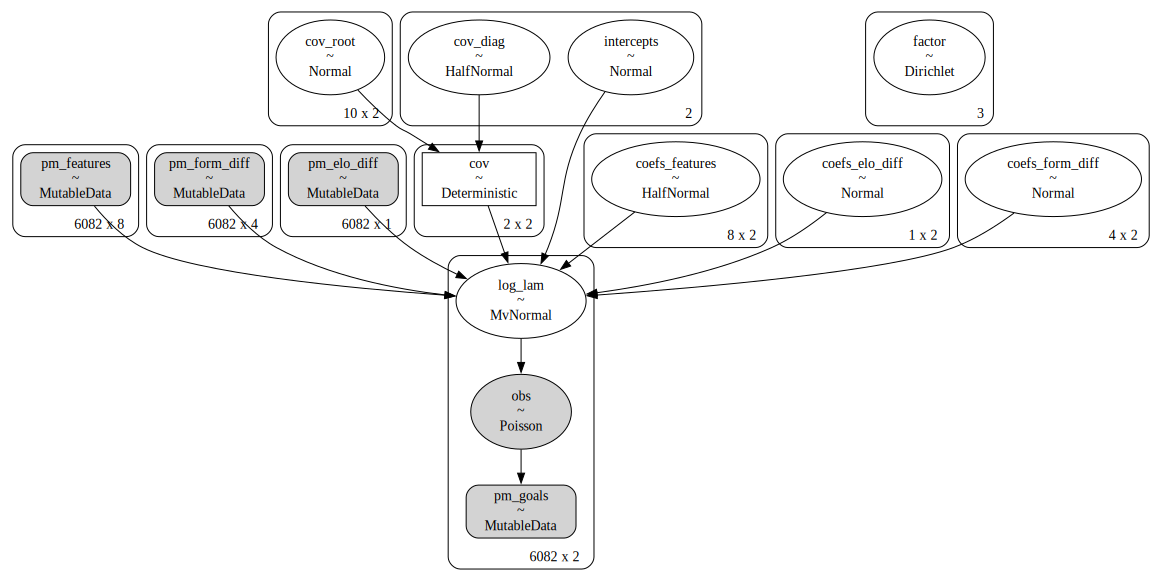

In [68]:
pm.model_to_graphviz(MODEL)

In [69]:
with MODEL:
    # trace = pm.sample(1000, tune=1000, return_inferencedata=True, discard_tuned_samples=True)
    app = pm.fit(50000, progressbar=True)
    trace = app.sample(1000)

Finished [100%]: Average Loss = 17,804


In [87]:
trace.to_netcdf("models/traces/dependent_trace.nc")

'models/traces/dependent_trace.nc'

In [70]:
az.summary(trace.posterior, var_names=["coefs_elo_diff", "coefs_form_diff", "coefs_features", "intercepts"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
"coefs_elo_diff[0, 0]",0.409,0.206,0.035,0.788
"coefs_elo_diff[0, 1]",-0.454,0.217,-0.856,-0.040
"coefs_form_diff[0, 0]",1.014,0.014,0.986,1.038
"coefs_form_diff[0, 1]",-0.103,0.018,-0.134,-0.068
"coefs_form_diff[1, 0]",-0.101,0.012,-0.126,-0.081
"coefs_form_diff[1, 1]",1.253,0.015,1.227,1.283
"coefs_form_diff[2, 0]",-0.219,0.013,-0.242,-0.196
"coefs_form_diff[2, 1]",1.189,0.014,1.162,1.215
"coefs_form_diff[3, 0]",0.908,0.014,0.884,0.936
"coefs_form_diff[3, 1]",-0.248,0.017,-0.280,-0.217


# Test

In [71]:
test_data = pd.read_csv("data_acquisition/data_0.3/data_game_values_test.csv", sep=";").dropna()


test_data_orig_size = test_data.shape[0]
size_diff = train_data.shape[0] - test_data.shape[0]
column_size = test_data.shape[1]
fill_data = [np.ones(column_size) for _ in range(size_diff)]
test_data_fill = pd.DataFrame(data=fill_data, columns=test_data.columns)
test_data = pd.concat([test_data, test_data_fill])

features = np.swapaxes(np.array([test_data["home_xG"] - xg_mean, test_data["away_xg_against"] - xg_against_mean,
                                test_data["away_xG"] - xg_mean, test_data["home_xg_against"] - xg_against_mean,
                                test_data["home_xT_all"] - xt_mean, test_data["away_xT_all"] - xt_mean,
                                test_data["home_xt_all_against"] - xt_against_mean, test_data["away_xt_all_against"] - xt_against_mean]), 0, 1)
# features_a = np.swapaxes(np.array([train_data["away_xG"], train_data["away_xT_only_pos"], train_data["home_xg_against"], train_data["home_xt_only_pos_against"]]), 0, 1)

gi = np.swapaxes(np.array([test_data["home_gi"], test_data["away_gi"]]), 0, 1)
# gi_a = np.swapaxes(np.array([train_data["away_gi"]]), 0, 1)

form = np.swapaxes(np.array([(test_data["ha_form_home_for"] / 5) - form_for_mean, (test_data["ha_form_home_against"] / 5) - form_against_mean,
                            (test_data["ha_form_away_for"] / 5) - form_for_mean, (test_data["ha_form_away_against"] / 5) - form_against_mean]), 0, 1)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(np.array([(test_data["elo_home"] / 1000) - (test_data["elo_away"] / 1000)]), 0, 1)

with MODEL:
    pm.set_data({"pm_elo_diff": elo,
                "pm_features": features,
                "pm_form_diff": form,})

    sample_res = pm.sample_posterior_predictive(trace, predictions=True)
    predictions = sample_res['predictions']

In [88]:
import pickle

In [89]:
# with open('dependent_predictions.pickle', 'wb') as handle:
#     pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
actual_home = test_data[:test_data_orig_size].home_score
actual_away = test_data[:test_data_orig_size].away_score
act_res = []
for h, a in zip(actual_home, actual_away):
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[:test_data_orig_size][:,:,0]
predictions_away = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[:test_data_orig_size][:,:,1]
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6])
    away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6])
    home, draw, away = 0, 0, 0
    for i in range(len(home_hist)):
        for j in range(len(away_hist)):
            if j < i:
                home += (home_hist[i]/1000) * (away_hist[j]/1000)
            elif j == i:
                draw += (home_hist[i]/1000) * (away_hist[j]/1000)
            elif j > i:
                away += (home_hist[i]/1000) * (away_hist[j]/1000)

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")
    most_goals["home"].append(f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%")
    most_goals["away"].append(f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%")

df_res = pd.DataFrame({"actual": act_res, "predicted": game_quotes, "prob goals home" : most_goals['home'], "prob goals away" : most_goals['away']})
df_cross = pd.DataFrame({"actual": [0 if int(df_res.iloc[i]['actual'].split(':')[0]) > int(df_res.iloc[i]['actual'].split(':')[1]) 
                                    else 1 if int(df_res.iloc[i]['actual'].split(':')[0]) == int(df_res.iloc[i]['actual'].split(':')[1])
                                    else 2
                                    for i in range(df_res.shape[0])],
                        "pred":   [np.argmax([float(y) for y in df_res.iloc[i]['predicted'].split('-')])
                                    for i in range(df_res.shape[0])],
                        "pred_val": [np.max([float(y) for y in df_res.iloc[i]['predicted'].split('-')])
                                    for i in range(df_res.shape[0])],
                        "bookie": [np.argmax([test_data.iloc[i].bookie_home, test_data.iloc[i].bookie_draw, test_data.iloc[i].bookie_away])
                                    for i in range(test_data_orig_size)],
                        "bookie_val": [np.max([test_data.iloc[i].bookie_home, test_data.iloc[i].bookie_draw, test_data.iloc[i].bookie_away])
                                    for i in range(test_data_orig_size)]
                                    })

In [73]:
df_res.head(25)

,actual,predicted,prob goals home,prob goals away
0,2:2,0.615-0.132-0.12,h: 2 - 22%,a: 0 - 46%
1,2:1,0.452-0.211-0.283,h: 1 - 28%,a: 0 - 35%
2,3:0,0.542-0.285-0.158,h: 1 - 31%,a: 0 - 62%
3,2:0,0.607-0.209-0.146,h: 1 - 26%,a: 0 - 55%
4,1:2,0.358-0.294-0.336,h: 0 - 39%,a: 0 - 43%
5,0:0,0.302-0.273-0.406,h: 0 - 42%,a: 0 - 35%
6,3:0,0.669-0.208-0.078,h: 1 - 24%,a: 0 - 71%
7,0:1,0.206-0.372-0.418,h: 0 - 62%,a: 0 - 44%
8,1:2,0.339-0.247-0.394,h: 0 - 36%,a: 0 - 32%
9,2:0,0.44-0.334-0.222,h: 0 - 39%,a: 0 - 58%


In [74]:
print("Verteilung:")
print(f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)", end = '')
print(f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%")
print(f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)", end = '')
print(f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%")
print(f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)", end = '')
print(f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%")
print("---------------------------------------------------------------------------------")
print("---------------------------------------------------------------------------------")
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {'act_away': 0, 'act_draw': 0}
draw_pred = {'act_away': 0, 'act_home': 0}
away_pred = {'act_home': 0, 'act_draw': 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred['act_draw'] += 1
            else:
                home_pred['act_away'] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred['act_home'] += 1
            else:
                draw_pred['act_away'] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred['act_home'] += 1
            else:
                away_pred['act_draw'] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred['act_away'] + home_pred['act_draw']
draw_wrong = draw_pred['act_away'] + draw_pred['act_home']
away_wrong = away_pred['act_home'] + away_pred['act_draw']
print("Prediction:")
print(f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)")
print("---------------------------------------------------------------------------------")
print(f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}")
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}")
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}")
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")



Verteilung:
Anzahl Predicted Home: 926 (59.94%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 51 (3.3%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 568 (36.76%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 899 (58.19%), Anzahl Falsch: 646 (41.81%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 554 (83.81%), Anzahl Home Falsch: 372
Home Pred. aber Draw --> 218
Home Pred. aber Away --> 154
Anzahl Draw Korrekt: 24 (6.09%), Anzahl Draw Falsch: 27
Draw Pred. aber Home --> 12
Draw Pred. aber Away --> 15
Anzahl Away Korrekt: 321 (65.51%), Anzahl Away Falsch: 247
Away Pred. aber Home --> 95
Away Pred. aber Draw --> 152


In [75]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6])
    away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6])
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

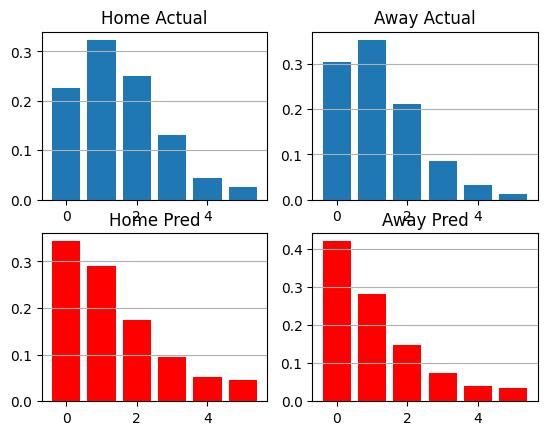

In [76]:
his_h, _ = np.histogram(train_data.home_score, [0,1,2,3,4,5,6])
his_a, _ = np.histogram(train_data.away_score, [0,1,2,3,4,5,6])
fig, (ax1, ax2) = plt.subplots(2, 2)
ax1[0].bar(np.arange(len(his_h)),his_h / np.sum(his_h))
ax1[0].set_title("Home Actual")
ax1[0].grid(axis='y')

ax2[0].bar(np.arange(len(home_cum_hist)),home_cum_hist / np.sum(home_cum_hist), color='r')
ax2[0].set_title("Home Pred")
ax2[0].grid(axis='y')

ax1[1].bar(np.arange(len(his_a)),his_a / np.sum(his_a))
ax1[1].set_title("Away Actual")
ax1[1].grid(axis='y')

ax2[1].bar(np.arange(len(away_cum_hist)),away_cum_hist / np.sum(away_cum_hist), color='r')
ax2[1].set_title("Away Pred")
ax2[1].grid(axis='y')

Text(0.5, 1.0, 'Pred Top Result')

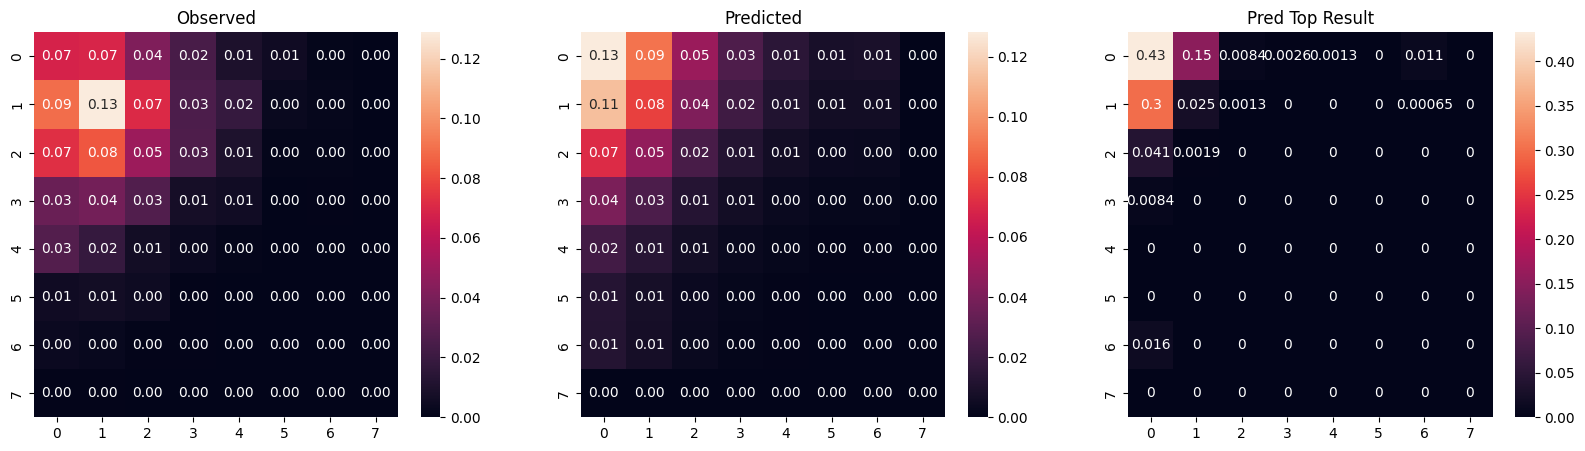

In [77]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

#predicted
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
    away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    probs = probs
    res_table_p += probs

res_table_p = res_table_p / test_data_orig_size

# sb.heatmap(res_table_p, annot=True)

# top pred result:
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
    away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
    res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
res_table_pr = res_table_pr / test_data_orig_size
# sb.heatmap(res_table_pr, annot=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt='.2f')
axes[0].set_title("Observed")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt='.2f')
axes[1].set_title("Predicted")
sb.heatmap(ax=axes[2], data=res_table_pr, annot=True)
axes[2].set_title("Pred Top Result")

In [78]:
print(np.tril(res_table_a).sum()-np.trace(res_table_a))
print(np.trace(res_table_a))
print(np.triu(res_table_a).sum()-np.trace(res_table_a))

0.4278317152103559
0.25501618122977343
0.31715210355987045


In [79]:
print(np.tril(res_table_p).sum()-np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum()-np.trace(res_table_p))

0.4076424977346279
0.23810160129449856
0.31802998381877046


In [80]:
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table += probs


# for x in range(len(res_table)):
#     for y in range(len(res_table[x])):
#         if x == y:
#             res_table[x][y] *= 1.2
#         else:
#             res_table[x][y] *= 0.95

# res_table = res_table / test_data_orig_size
# print(sum(sum(res_table)))
# sb.heatmap(res_table, annot=True)

In [81]:
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
    away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))
    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    for x in range(len(probs)):
        for y in range(len(probs[x])):
            if x == y:
                probs[x][y] *= 1.3
            else:
                probs[x][y] *= (1-0.085)
    home = np.tril(probs).sum()-np.trace(probs)
    draw = np.trace(probs)
    away = np.triu(probs).sum()-np.trace(probs)
    game_quotes.append(f"{home}-{draw}-{away}")
    most_goals["home"].append(f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%")
    most_goals["away"].append(f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%")

df_res = pd.DataFrame({"actual": act_res, "predicted": game_quotes, "prob goals home" : most_goals['home'], "prob goals away" : most_goals['away']})
df_cross = pd.DataFrame({"actual": [0 if int(df_res.iloc[x]['actual'].split(':')[0]) > int(df_res.iloc[x]['actual'].split(':')[1]) 
                                    else 1 if int(df_res.iloc[x]['actual'].split(':')[0]) == int(df_res.iloc[x]['actual'].split(':')[1])
                                    else 2
                                    for x in range(df_res.shape[0])],
                         "pred":   [np.argmax([float(y) for y in df_res.iloc[x]['predicted'].split('-')])
                                    for x in range(df_res.shape[0])],
                         "pred_val": [np.max([float(y) for y in df_res.iloc[x]['predicted'].split('-')])
                                    for x in range(df_res.shape[0])],
                         "bookie": [np.argmax([test_data.iloc[x].bookie_home, test_data.iloc[x].bookie_draw, test_data.iloc[x].bookie_away])
                                    for x in range(test_data_orig_size)],
                         "bookie_val": [np.max([test_data.iloc[x].bookie_home, test_data.iloc[x].bookie_draw, test_data.iloc[x].bookie_away])
                                    for x in range(test_data_orig_size)]
                                    })

In [82]:
print("Verteilung:")
print(f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)", end = '')
print(f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%")
print(f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)", end = '')
print(f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%")
print(f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)", end = '')
print(f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%")
print("---------------------------------------------------------------------------------")
print("---------------------------------------------------------------------------------")
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {'act_away': 0, 'act_draw': 0}
draw_pred = {'act_away': 0, 'act_home': 0}
away_pred = {'act_home': 0, 'act_draw': 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred['act_draw'] += 1
            else:
                home_pred['act_away'] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred['act_home'] += 1
            else:
                draw_pred['act_away'] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred['act_home'] += 1
            else:
                away_pred['act_draw'] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred['act_away'] + home_pred['act_draw']
draw_wrong = draw_pred['act_away'] + draw_pred['act_home']
away_wrong = away_pred['act_home'] + away_pred['act_draw']
print("Prediction:")
print(f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)")
print("---------------------------------------------------------------------------------")
print(f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}")
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}")
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}")
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")



Verteilung:
Anzahl Predicted Home: 769 (49.77%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 304 (19.68%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 472 (30.55%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 867 (56.12%), Anzahl Falsch: 678 (43.88%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 477 (72.16%), Anzahl Home Falsch: 292
Home Pred. aber Draw --> 169
Home Pred. aber Away --> 123
Anzahl Draw Korrekt: 109 (27.66%), Anzahl Draw Falsch: 195
Draw Pred. aber Home --> 109
Draw Pred. aber Away --> 86
Anzahl Away Korrekt: 281 (57.35%), Anzahl Away Falsch: 191
Away Pred. aber Home --> 75
Away Pred. aber Draw --> 116


In [83]:
# ece
data_length = df_cross.shape[0]

acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
acc_bookie = np.sum(df_cross['bookie'] == df_cross['pred']) / data_length

print(acc_model)
print(acc_bookie)

conf_model = np.sum(df_cross['pred_val']) / data_length
conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

print(conf_model)
print(conf_bookie)

ece_model = np.mean(np.absolute(acc_model - conf_model))
ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

print(f"Model ECE: {ece_model}")
print(f"Bookie ECE: {ece_bookie}")

0.5611650485436893
0.6608414239482201
0.4737307173656958
0.5229518832996787
Model ECE: 0.08743433117799354
Bookie ECE: 0.13788954064854142


In [84]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(':')
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split('-')
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = test_data.iloc[idx].bookie_home, test_data.iloc[idx].bookie_draw, test_data.iloc[idx].bookie_away
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk*(100 / bookie_h)-risk
        else: 
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk*(100 / bookie_d)-risk
        else: 
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk*(100 / bookie_a)-risk
        else: 
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 824
won: 345
lost: 479
money:  5413.173951973651


In [85]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(':')
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split('-')
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = test_data.iloc[idx].bookie_home, test_data.iloc[idx].bookie_draw, test_data.iloc[idx].bookie_away
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk*(100 / bookie_h)-risk
        else: 
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk*(100 / bookie_d)-risk
        else: 
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk*(100 / bookie_a)-risk
        else: 
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 130
won: 118
lost: 12
money:  707.8091890584158


In [86]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(':')
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split('-')
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = test_data.iloc[idx].bookie_home, test_data.iloc[idx].bookie_draw, test_data.iloc[idx].bookie_away
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk*(100 / bookie_h)-risk
        else: 
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold  or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk*(100 / bookie_d)-risk
        else: 
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold  or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk*(100 / bookie_a)-risk
        else: 
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 920
won: 434
lost: 486
money:  5767.190449771764
